In [68]:
import os
from sklearn.decomposition import PCA
import cv2
import matplotlib.image as mplib
import numpy as np
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import graphviz
print('done')

done


Let's start.
Here we define path to directories:
p - folder of people with mask
n - folder of people without mask
which were prepared before using VJ algorithm to detect faces of people on the images from our dataset

In [69]:
n_comp = 15
#the directories to change
p = '/Users/max/Desktop/Study/Project/submission/Medical Mask/p/'
n = '/Users/max/Desktop/Study/Project/submission/Medical Mask/n/'
print('done')

done


Next we prepare array of pictures (X) and array of labels (y) to work with.
We reading each picture, reshape to 224x224, convert to gray and append it to X, and append to y right label (with_mask/without_mask).
Why reshaping? Because we want that each image will be in the same format for easier way to work with it.
Why convert to gray? A number of reasons:
1) we don't need color for detecting mask on the face
2) the code becomes less complex
3) process of machine learning becomes much faster using gray images and not colored

In [70]:
X = []
y = []
for filename in os.listdir(p):
    img = cv2.imread(p + filename)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    temp = []
    for i in range(0, 224):
        temp.append([])
        for j in range(0, 224):
            temp[i].append(img[i][j])
    X.append(temp)
    y.append('with_mask')
for filename in os.listdir(n):
    img = cv2.imread(n + filename)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    temp = []
    for i in range(0, 224):
        temp.append([])
        for j in range(0, 224):
            temp[i].append(img[i][j])
    temp = np.array(temp)
    X.append(temp)
    y.append('without_mask')    
print('done')
print(len(X))
print(len(y))

done
3689
3689


Well, now our dataset ready for work.
In the next section we split it to the train and test. Than we convert the result arrays (X_train, X_test) to 2d arrays (because estimator that we're going to use takes only 2d arrays) using numpy. We make dimensionality reduction using PCA (from sklearn.decomposition) with n_components = 50 (as was found it's optimal number, so we leave only 50 dimensions and save about 90% of information of the original image) and whiten=True to improve the predictive accuracy. And then we transform X_train and X_test to PCA version.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X,y)
components_n = 50
pca = PCA(n_components = components_n, whiten=True)
n_samples, nx, ny = len(X_train), len(X_train[0]), len(X_train[0][1])
d2_Xtrain = np.array(X_train).reshape((n_samples, nx*ny))
n_samples, nx, ny = len(X_test), len(X_test[0]), len(X_test[0][1])
d2_Xtest = np.array(X_test).reshape((n_samples, nx*ny))
pca = pca.fit(d2_Xtrain)
print(pca.explained_variance_ratio_)
e_faces = pca.components_
X_train_pca = pca.transform(d2_Xtrain)
X_test_pca = pca.transform(d2_Xtest)
print('done')

[0.22862241 0.11743538 0.0727437  0.07010684 0.04274668 0.03080733
 0.02075533 0.01872017 0.01667749 0.01619501 0.01435898 0.01132496
 0.01052507 0.00959024 0.00881494 0.008149   0.00697879 0.0063967
 0.00596472 0.00570997 0.00551982 0.00508933 0.00479507 0.00445942
 0.0043917  0.00390439 0.0037861  0.00372516 0.00355795 0.00322146
 0.00316596 0.00313455 0.00300226 0.00298867 0.00290265 0.00276424
 0.00264075 0.00258402 0.00240985 0.00234665 0.00232064 0.00218685
 0.00209644 0.00205632 0.00200865 0.0019323  0.00191165 0.00188627
 0.00180923 0.00177249]
done


    Let's see the explained variance ratio as a function of number of components over the PCA we've done on the dataset:

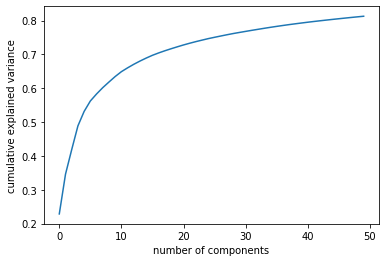

In [71]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

To gain some intuition into the relationships between these points, we can use PCA to project them to a more manageable number of dimensions, say two. We can now plot the first two principal components of each point to learn about the data:
lets start with the train:

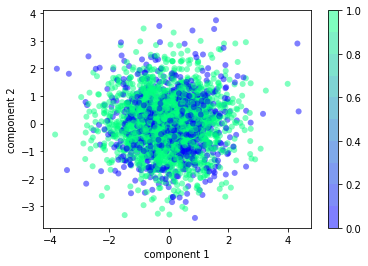

In [76]:
pca2 = pca
c = []
for v in y_train:
    if v == 'with_mask':
        c.append(1)
    else:
        c.append(0)
projected = pca2.fit_transform(X_train_pca)
plt.scatter(projected[:, 0], projected[:, 1],
            c=c, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('winter', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Test:

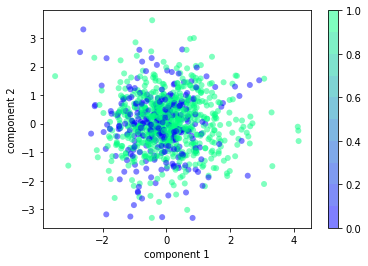

In [77]:
pca2 = pca
c = []
for v in y_test:
    if v == 'with_mask':
        c.append(1)
    else:
        c.append(0)
projected = pca2.fit_transform(X_test_pca)
plt.scatter(projected[:, 0], projected[:, 1],
            c=c, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('winter', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

to get a better visuallization lets look at 3 components pca

In [130]:
pca3 = PCA(n_components = 3, whiten=True)
pca3 = pca3.fit(d2_Xtrain)
X_train_pca3 = pca3.transform(d2_Xtrain)
X_test_pca3 = pca3.transform(d2_Xtest)

Next we'll plot the pca result but for now we do it in 3D:

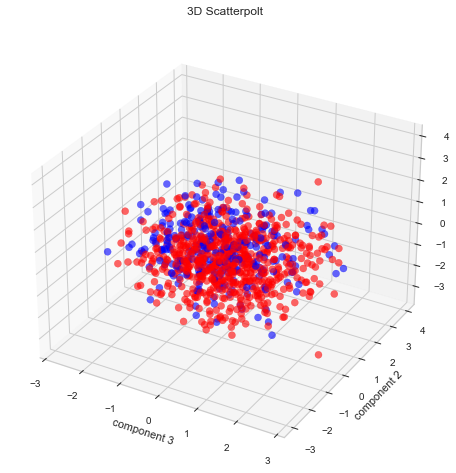

In [139]:
from mpl_toolkits import mplot3d

fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')
rgbs = []
for value in c:
    if value == 1:
        rgbs.append('#FF0000')
    else:
        rgbs.append('#0000FF')
sctt = ax.scatter3D(X_test_pca3[:,0],X_test_pca3[:,1],X_test_pca3[:,2], c=rgbs, s=50, alpha = 0.6)

plt.title("3D Scatterpolt",pad=15)
ax.set_xlabel('component 1')
ax.set_ylabel('component 2')
ax.set_xlabel('component 3')
plt.savefig('3d_fig.png')


Net we will try to use some classification algorithms:
1 SVR (kernel = rbf/linear/poly, gamma = scale/auto)
2 Random forest (n_estimators = 50/100/150, criterion = gini/entropy)
3 KNN (n_neighbors = 2/3/5, algorithm = ball_tree/kd_tree/brute)
To understand how good (or bad) the model work we use function 'classification_report' from sklearn.metrics that build a text report showing the main classification metrics such as precision, recall, f1-score. For each model and for different parameters we print report and see how good it was.

----------------------------------------------------------------
SVR
(923, 50)
(923,)


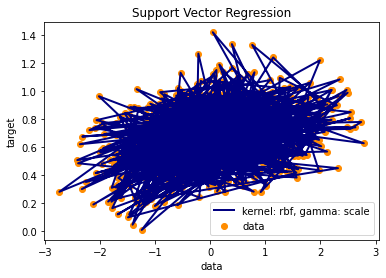

kernel: rbf, gamma: scale
              precision    recall  f1-score   support

   with_mask       0.58      0.39      0.46       269
without_mask       0.78      0.88      0.83       654

    accuracy                           0.74       923
   macro avg       0.68      0.64      0.65       923
weighted avg       0.72      0.74      0.72       923

(923, 50)
(923,)


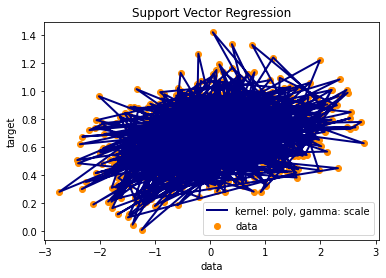

kernel: poly, gamma: scale
              precision    recall  f1-score   support

   with_mask       0.58      0.39      0.46       269
without_mask       0.78      0.88      0.83       654

    accuracy                           0.74       923
   macro avg       0.68      0.64      0.65       923
weighted avg       0.72      0.74      0.72       923

(923, 50)
(923,)


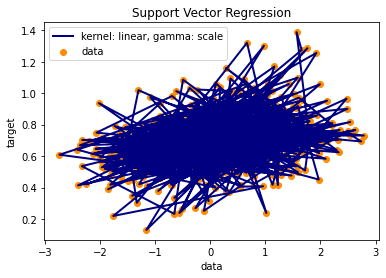

kernel: linear, gamma: scale
              precision    recall  f1-score   support

   with_mask       0.57      0.14      0.23       269
without_mask       0.73      0.95      0.83       654

    accuracy                           0.72       923
   macro avg       0.65      0.55      0.53       923
weighted avg       0.68      0.72      0.65       923

(923, 50)
(923,)


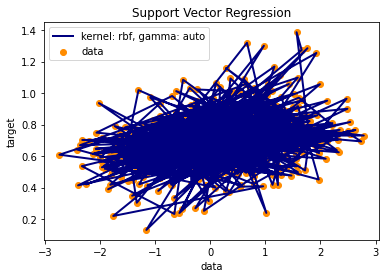

kernel: rbf, gamma: auto
              precision    recall  f1-score   support

   with_mask       0.57      0.14      0.23       269
without_mask       0.73      0.95      0.83       654

    accuracy                           0.72       923
   macro avg       0.65      0.55      0.53       923
weighted avg       0.68      0.72      0.65       923

(923, 50)
(923,)


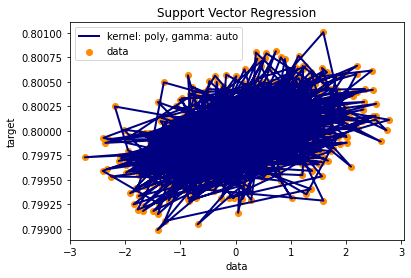

kernel: poly, gamma: auto
              precision    recall  f1-score   support

   with_mask       0.00      0.00      0.00       269
without_mask       0.71      1.00      0.83       654

    accuracy                           0.71       923
   macro avg       0.35      0.50      0.41       923
weighted avg       0.50      0.71      0.59       923

(923, 50)
(923,)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

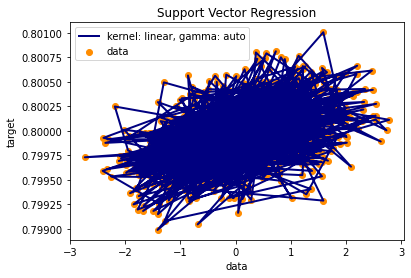

kernel: linear, gamma: auto
              precision    recall  f1-score   support

   with_mask       0.00      0.00      0.00       269
without_mask       0.71      1.00      0.83       654

    accuracy                           0.71       923
   macro avg       0.35      0.50      0.41       923
weighted avg       0.50      0.71      0.59       923



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [61]:
# SVR
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
print('----------------------------------------------------------------')
print('SVR')
svrs = []
y_train_bin = []
y_test_bin = []
kernels = ['rbf', 'poly', 'linear']
gammas = ['scale', 'auto']
for value in y_train:
    if value == 'with_mask':
        y_train_bin.append(1)
    else:
        y_train_bin.append(0)
for value in y_test:
    if value == 'with_mask':
        y_test_bin.append(1)
    else:
        y_test_bin.append(0)
for kernel in kernels:
    for gamma in gammas:
        clf = SVR(C=1.0, epsilon=0.2, kernel=kernel, gamma=gamma)
        clf.fit(X_train_pca, y_train_bin)
        svrs.append(clf)
ix = 0
for svr in svrs:
    temp = svr.predict(X_test_pca)
    pred = []
    y = temp
    lw = 2
    print(X_test_pca.shape)
    print(y.shape)
    plt.scatter(X_test_pca[:,0], y, color='darkorange', label='data')
    #plt.hold('on')
    plt.plot(X_test_pca[:,0], y, color='navy', lw=lw, label='kernel: ' + kernels[ix%3] + ', gamma: ' + gammas[int(ix/3)])
    plt.xlabel('data')
    plt.ylabel('target')
    plt.title('Support Vector Regression')
    plt.legend()
    plt.show()
    for v in temp:
        if v > 0.5:
            pred.append(1)
        else:
            pred.append(0)
    print('kernel: ' + kernels[ix%3] + ', gamma: ' + gammas[int(ix/3)])
    ix += 1
    print(classification_report(y_test_bin, pred, target_names = ['with_mask', 'without_mask']))

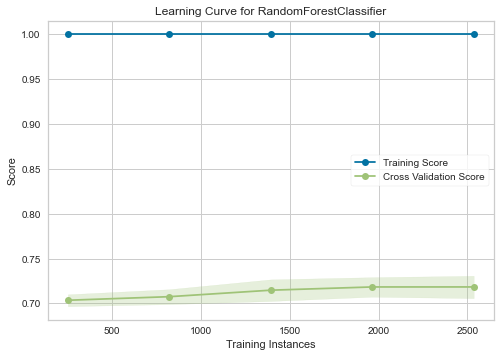

In [126]:
cv = StratifiedKFold(n_splits=12, random_state=42, shuffle=True)
# next line don't work, having troubles with this func. 
# it's plot the graph with accuracy that we've got but we have valueerror after that
# ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
# we use try and except to make the result look more clean
try:
    print(learning_curve(clf, X_train_pca, y_train, cv=cv, scoring='accuracy'))
except:
    pass

----------------------------------------------------------------
KNN
Found best KNN! Classification report:
Using 5 neighbors, brute algorithm:
              precision    recall  f1-score   support

   with_mask       0.75      0.79      0.77       654
without_mask       0.41      0.36      0.38       269

    accuracy                           0.66       923
   macro avg       0.58      0.57      0.58       923
weighted avg       0.65      0.66      0.66       923

scores:  [0.6576381365113759, 0.6933911159263272, 0.6457204767063922, 0.6901408450704225, 0.6630552546045504, 0.6814734561213435, 0.6619718309859155, 0.6836403033586133, 0.6879739978331527, 0.6998916576381365, 0.6836403033586133, 0.6977248104008668, 0.6923076923076923, 0.695557963163597, 0.6944745395449621, 0.7020585048754063, 0.6998916576381365, 0.7085590465872156, 0.6988082340195017, 0.7128927410617552, 0.7031419284940412, 0.7107258938244854, 0.7085590465872156, 0.7128927410617552]


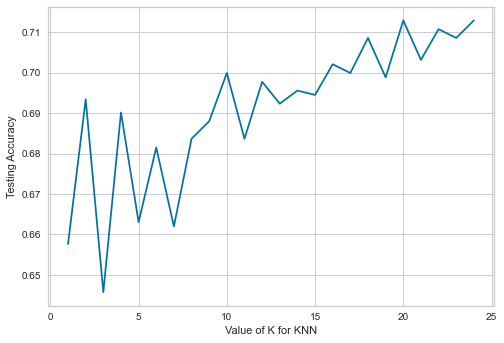

----------------------------------------------------------------
Random forest
Found best random forest! Classification report:
Using 150 estimators and entropy criterion:
              precision    recall  f1-score   support

   with_mask       0.72      0.98      0.83       654
without_mask       0.67      0.07      0.13       269

    accuracy                           0.72       923
   macro avg       0.69      0.53      0.48       923
weighted avg       0.71      0.72      0.63       923



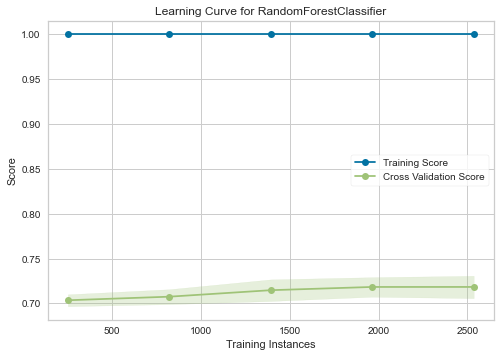

In [140]:
justcounter = 0
# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
print('----------------------------------------------------------------')
print('KNN')
max_grade = 0.0
best_model = None
clf_rep = ''
title = ''
title = 'Learning curve (KNN)'
scores = []
k = 0
for neigh in [2,3,5]:
    for alg in ['ball_tree', 'kd_tree', 'brute']:
        clf = KNeighborsClassifier(n_neighbors=neigh, algorithm=alg)
        clf.fit(X_train_pca, y_train)
        pred = clf.predict(X_test_pca)
        cr_dict = classification_report(y_test, pred, target_names = ['with_mask', 'without_mask'], output_dict=True)
        model_grade = 0.0
        for cl in cr_dict:
            if cl in ['accuracy', 'macro avg', 'weighted avg']:
                continue
            model_grade += cr_dict[cl]['precision'] + cr_dict[cl]['recall']
        if max_grade < model_grade:
            max_grade < model_grade
            best_model = clf
            clf_rep = classification_report(y_test, pred, target_names = ['with_mask', 'without_mask'])
            title = 'Using ' + str(neigh) + ' neighbors, ' + alg + ' algorithm:'
            k = neigh
k_range = range(1, 25)
if best_model is not None:
    print('Found best KNN! Classification report:')
    print(title)
    print(clf_rep)
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_pca, y_train)
        y_pred = knn.predict(X_test_pca)
        scores.append(metrics.accuracy_score(y_test, y_pred))
    print('scores: ', scores)
    plt.plot(k_range, scores)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Testing Accuracy')
toshow.show()
plt.show()

# Random forest
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
print('----------------------------------------------------------------')
print('Random forest')
max_grade = 0.0
best_model = None
clf_rep = ''
title = ''
title = 'Learning curve (Random Forest)'
n_est_best = None
crit_best = None
for n_est in [50,100,150]:
    for crit in ['gini', 'entropy']:
        clf = RandomForestClassifier(random_state=0, n_estimators=n_est, criterion=crit)
        clf.fit(X_train_pca, y_train)
        pred = clf.predict(X_test_pca)
        cr_dict = classification_report(y_test, pred, target_names = ['with_mask', 'without_mask'], output_dict=True)
        model_grade = 0.0
        for cl in cr_dict:
            try:
                model_grade += cr_dict[cl]['precision'] + cr_dict[cl]['recall']
            except:
                justcounter += 1
        if max_grade < model_grade:
            n_est_best = n_est
            crit_best = crit
            max_grade < model_grade
            best_model = clf
            clf_rep = classification_report(y_test, pred, target_names = ['with_mask', 'without_mask'])
            title = 'Using ' + str(n_est) + ' estimators and ' + crit + ' criterion:'
if best_model is not None:
    print('Found best random forest! Classification report:')
    print(title)
    print(clf_rep)
    ######################
    rfc = RandomForestClassifier(random_state=0, n_estimators=n_est_best, criterion=crit_best)
    cv = StratifiedKFold(n_splits=12, random_state=42, shuffle=True)
    # next line don't work, having troubles with this func. 
    # it's plot the graph with accuracy that we've got but we have valueerror after that
    # ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
    # we use try and except to make the result look more clean
    try:
        print(learning_curve(rfc, X_train_pca, y_train, cv=cv, scoring='accuracy'))
    except:
        pass
plt.show()

Let's try to use the decision tree to validate our work on dataset. We'll normalize our train set by l2 norm and then we build decision tree classifier with depths 3, 5, 10, 20 and 40 and check what was the best result.

The decision trees graph we save as pdf, added to the zip file :)

depth:  3
[learning_curve] Training set sizes: [  8  25  41  58  75  92 108 125 142 159 175 192 209 226 243 259 276 293
 310 326 343 360 377 393 410 427 444 461 477 494 511 528 544 561 578 595
 611 628 645 662 679 695 712 729 746 762 779 796 813 830]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.8s finished


depth:  5
[learning_curve] Training set sizes: [  8  25  41  58  75  92 108 125 142 159 175 192 209 226 243 259 276 293
 310 326 343 360 377 393 410 427 444 461 477 494 511 528 544 561 578 595
 611 628 645 662 679 695 712 729 746 762 779 796 813 830]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.1s finished


depth:  10
[learning_curve] Training set sizes: [  8  25  41  58  75  92 108 125 142 159 175 192 209 226 243 259 276 293
 310 326 343 360 377 393 410 427 444 461 477 494 511 528 544 561 578 595
 611 628 645 662 679 695 712 729 746 762 779 796 813 830]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.4s finished


depth:  20
[learning_curve] Training set sizes: [  8  25  41  58  75  92 108 125 142 159 175 192 209 226 243 259 276 293
 310 326 343 360 377 393 410 427 444 461 477 494 511 528 544 561 578 595
 611 628 645 662 679 695 712 729 746 762 779 796 813 830]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.4s finished


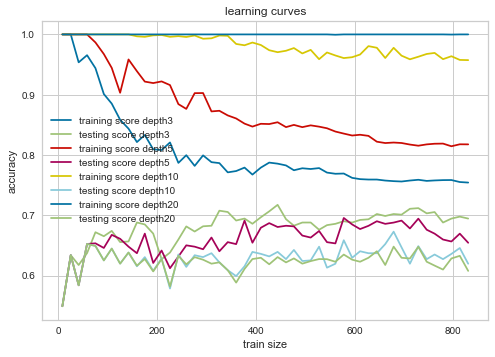

In [150]:
import cv2
from sklearn.model_selection import learning_curve

nsamples, nx, ny = len(X_train), len(X_train[0]), len(X_train[0][0])
prep_Xtrain = preprocessing.normalize(np.array(X_train).reshape((nsamples, nx*ny)), norm='l2')
for i in [3, 5, 10, 20]:
    print('depth: ',i)
    clf = DecisionTreeClassifier(max_depth=i, random_state=0)
    clf.fit(prep_Xtrain, y_train)
    dot_data = tree.export_graphviz(clf, out_file=None, filled=True, rounded=True, class_names=['with_mask', 'without_mask'])
    g = graphviz.Source(dot_data)
    g.render('try: tree_' + str(i))
    train_sizes, train_scores,test_scores = learning_curve(clf, X_test_pca, y_test, cv=10,scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01,1,50), verbose=1)
    train_mean = np.mean(train_scores,axis=1)
    test_mean = np.mean(test_scores,axis=1)
    test_std=np.std(test_scores, axis=1)
    plt.plot(train_sizes, train_mean, label='training score depth' + str(i))
    plt.plot(train_sizes, test_mean, label='testing score depth' + str(i))
    plt.title('learning curves')
    plt.xlabel('train size')
    plt.ylabel('accuracy')
    plt.legend(loc='best')


Next, for validation, we classify the images using support vector classification algorithm (SVC) with kernel=rbf and finding the best estimator to predict, and then print confusion matrix to see the output results (about 73%).
Because of low percentrage of SVC we need to use more complex model to get higher result, for example CNN.

In [115]:
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
svc = SVC(kernel='rbf')
clf = GridSearchCV(svc, param_grid)
clf.fit(X_train_pca, y_train)
print("Best estimator is: ", clf.best_estimator_)
pred = clf.predict(X_test_pca)
print(classification_report(y_test, pred, target_names = ['with_mask', 'without_mask']))
print(confusion_matrix(y_test, pred))
print('done')

Best estimator is:  SVC(C=1000.0, gamma=0.0005)
              precision    recall  f1-score   support

   with_mask       0.77      0.89      0.82       654
without_mask       0.57      0.35      0.43       269

    accuracy                           0.73       923
   macro avg       0.67      0.62      0.63       923
weighted avg       0.71      0.73      0.71       923

[[582  72]
 [175  94]]
done
